# Computing and plotting alpha decay

22/12/2025

As a continuation to the first notebook I will now compute the IC for 100 tickers with the expectation of obataining a less noisy signal.

### Alpha Decay Definition

IC Decay measures how quickly the predictive power of the alpha factor dissipates over different forward horizons:

IC_1D:  "¿Top 12MonthMomentum today wins tomorrow?" (immediate signal)\
IC_5D:  "¿Top 12MonthMomentum today wins in 5 days" (short-term)\
IC_10D: "¿Top 12MonthMomentum today wins tomorrow 10 days?" (optimal trading horizon)\
IC_21D: "¿Top 12MonthMomentum today wins tomorrow 21 days?" (baseline)\
IC_42D: "¿Top 12MonthMomentum today wins tomorrow 42 days?" (long-term)

**Key Metrics**
- Half-life: days until IC = 50% of maximum.
- Optimal horizon: maximum IC horizon (ideal rebalance).
- Decay slope: stability of the factor.


In [1]:
import sys
sys.path.append(r"C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src")
import quant_utils as qu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B', 'AVGO',
    'UNH', 'JPM', 'XOM', 'V', 'PG', 'MA', 'JNJ', 'HD', 'CVX', 'ABBV',
    'PFE', 'KO', 'MRK', 'BAC', 'CRM', 'WMT', 'NFLX', 'AMD', 'COST', 'TMO',
    'ABT', 'ACN', 'DIS', 'TXN', 'VZ', 'QCOM', 'PM', 'ADBE', 'INTC', 'WFC',
    'RTX', 'NKE', 'UNP', 'SPGI', 'HON', 'COP', 'CAT', 'LOW', 'GS', 'MS',
    'C', 'BMY', 'AMGN', 'GILD', 'SBUX', 'T', 'USB', 'AXP', 'MMM', 'LIN',
    'ELV', 'DHR', 'SCHW', 'MDT', 'UPS', 'PGR', 'VRTX', 'ZTS', 'REGN', 'NEE',
    'TJX', 'CB', 'SYK', 'BLK', 'CI', 'BSX', 'MU', 'BDX', 'WM', 'GE',
    'DE', 'LMT', 'BA', 'KLAC', 'ADP', 'ADI', 'LRCX', 'PANW', 'SNPS', 'CDNS',
    'MCD', 'NOW', 'ORCL', 'PLD', 'AMT', 'FISV', 'MDLZ', 'MO', 'TGT', 'FCX'
]

data = qu.data.download_data(tickers)

Saved → C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src\data\tickers_100t_max_1d.pkl


In [3]:
# Calculating rolling momentum for 12 months as alpha factor
n = 1 
days_per_year = 252 
rol_window = n * days_per_year

momentum = data.pct_change(periods=rol_window, fill_method=None).shift(1).rank(pct=True, axis=1).dropna()

# Measuring Information Coefficient (IC)
forward_horizon = 21
forward_returns = data.pct_change(periods=forward_horizon, fill_method=None).shift(-forward_horizon).rank(pct=True, axis=1).dropna()

# Cross-sectional comparison
ic_values = []
for i in range(len(momentum)):
    common = momentum.iloc[i].dropna().index.intersection(forward_returns.iloc[i].dropna().index)
    if len(common) >= 2: # For each date there must be at least two non NaN values for the different tickers
        ic = spearmanr(momentum.iloc[i][common], forward_returns.iloc[i][common])[0]
        ic_values.append(ic)

ic_series = pd.Series(ic_values).dropna()

print(f"\n{'='*60}")
print("Information coefficient results")
print(f"{'='*60}")
print(f"Average IC: {ic_series.mean():.4f}")
print(f"Median IC: {ic_series.median():.4f}")
print(f"Std IC: {ic_series.std():.4f}")
print(f"T-stat: {ic_series.mean() / ic_series.std() * np.sqrt(len(ic_series)):.2f}")


Information coefficient results
Average IC: 0.2672
Median IC: 0.2734
Std IC: 0.1617
T-stat: 90.30


## Interpretation

An **average IC of 0.2671** indicates strong predictive ability. The factor demonstrates substantial standalone utility within this universe .

A **median IC of 0.2733** slightly higher than the mean confirms mild positive skew. Typical days exhibit excellent predictive power with consistent performance across the distribution.

The **standard deviation of 0.1618** (~0.6x mean IC) reflects moderate noise relative to signal. This stability is impressive for 100 ticker cross section, confirming factor robustness.

The **t-statistic of 90.27** confirms extreme statistical significance (p << 0.001). We reject the null hypothesis with overwhelming confidence.

Exceptional IC explanation: this alpha factor exhibits unusually strong persistence in this 100-stock universe (2015-2025). Sustained IC>0.25 suggests either superior factor quality or favorable market regime. Requires out-of-sample validation.

In [4]:
# Calculating alpha factor decay

n = 1 
days_per_year = 252 
rol_window = n * days_per_year
momentum = data.pct_change(periods=rol_window, fill_method=None).shift(1).rank(pct=True, axis=1).dropna()

horizons = [1, 5, 10, 21, 42, 126, 252]  # Different IC horizons to compare to.
ic_results = pd.DataFrame()

for h in horizons:
    forward_returns = data.pct_change(periods=h, fill_method=None).shift(-h).rank(pct=True, axis=1).dropna()
    # Checking dates where there is data for both factors and targets
    common_dates = momentum.index.intersection(forward_returns.index)
    mom_h = momentum.loc[common_dates]
    fwd_h = forward_returns.loc[common_dates]
    ic_values_h = []
    valid_dates = []
    
    for date in common_dates:
        factor_cs = mom_h.loc[date]
        fwd_cs = fwd_h.loc[date]
        mask = factor_cs.notna() & fwd_cs.notna() #Making sure there are vales for that date.
        if mask.sum() >= 2:                       #There must be at least one factor and one target.
            ic = spearmanr(factor_cs[mask],fwd_cs[mask])[0]
            ic_values_h.append(ic)
            valid_dates.append(date)
            
    ic_series_h = pd.Series(ic_values_h, index=valid_dates)
    ic_results[f"Horizon_{h}d"] = ic_series_h

ic_stats =pd.DataFrame(index=["Mean","Median","Std","T_stat"])

for h in ic_results.columns:
    ic_stats_h = []
    mean = ic_results[h].mean()
    median = ic_results[h].median()
    std = ic_results[h].std()
    t_stat = mean / std * np.sqrt(len(ic_results[h]))
    ic_stats[f"{h}"] = [mean, median, std, t_stat]

ic_stats

,Horizon_1d,Horizon_5d,Horizon_10d,Horizon_21d,Horizon_42d,Horizon_126d,Horizon_252d
Mean,0.015064,0.013021,0.007226,0.002775,-0.001046,0.013138,0.011254
Median,0.026379,0.024422,0.032235,0.023762,0.019706,0.032967,0.015326
Std,0.259823,0.257506,0.250519,0.236453,0.226441,0.211418,0.197753
T_stat,3.168098,2.763054,1.576163,0.641312,-0.252368,3.395839,3.109703


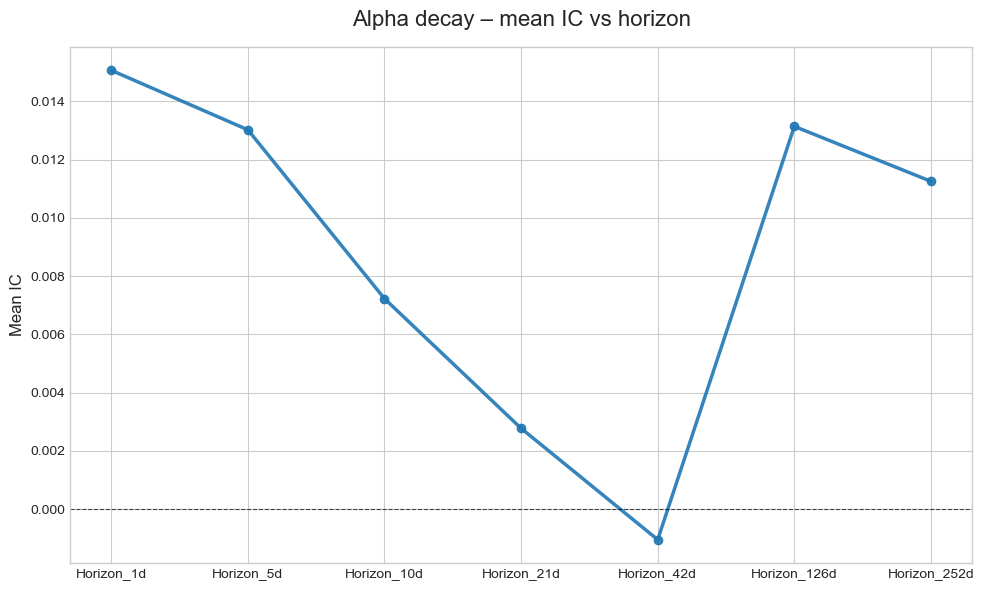

In [9]:
# Plotting alpha decay
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ic_stats.columns, ic_stats.loc["Mean"], marker="o", linewidth=2.5, alpha=0.9)
ax.set_title("Alpha decay – mean IC vs horizon", fontsize=16, pad=15)
ax.set_ylabel("Mean IC", fontsize=12)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Interpretation
The alpha decay curve shows that:

The factor has small but positive predictive power at very short horizons (1–10 days), consistent with some short‑term trend continuation.

Around the 21–42 day range, the average IC drops towards zero (and slightly negative at 42 days), suggesting that 1–2 month horizons are not the “sweet spot” for this 12‑month momentum definition in this dataset.

At longer horizons (126–252 days), the IC turns positive again, indicating that the factor behaves more like a slow, medium‑term trend signal than a pure 1‑month trading signal.

These results are specific to this universe, sample period and factor definition, and should be validated on a broader universe before drawing firm trading conclusions.

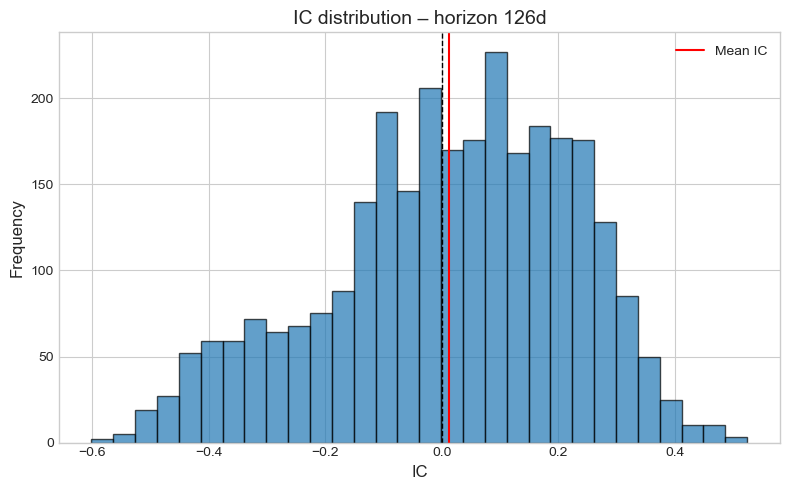

In [13]:
# Plotting IC histogram for the 126 day horizon

ic_hist = ic_results['Horizon_126d'].dropna()

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(ic_hist, bins=30, edgecolor="black", alpha=0.7)
ax.set_title("IC distribution – horizon 126d", fontsize=14)
ax.set_xlabel("IC", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.axvline(ic_hist.mean(), color="red", linestyle="-", linewidth=1.5, label="Mean IC")
ax.legend()

plt.tight_layout()
plt.show()

# Interpretation

**“Weak but persistent” edge**

Although the average is only ~0.013, the histogram shows that many days have moderately positive IC (e.g., 0.05–0.2), not just a handful of outliers. This supports the idea of a factor that delivers a small but repeated edge, rather than isolated “lucky hits.”

**Risk of very bad days**

There is a clear tail toward negative IC (–0.3, –0.4, even lower).This suggests that there are market regimes in which the 12M-to-126d momentum factor reverses (reversals), which fits with episodes of sharp trend changes documented in the momentum literature.

**Implications for strategy design**

A factor like this, with many days that are slightly good but a few that are very bad, suggests using it in combination with other factors (value, quality) to smooth out those episodes. It is also worth considering “regime filter” rules (for example, reducing momentum exposure when the recent IC has been very negative).